In [1]:
import pyabc
import numpy as np
import scipy as sp
import os
from study_abc_noise.model import ConversionReactionModelVars as ModelVars
import matplotlib.pyplot as plt
%matplotlib inline

## Iterations plot with true density for one n_t

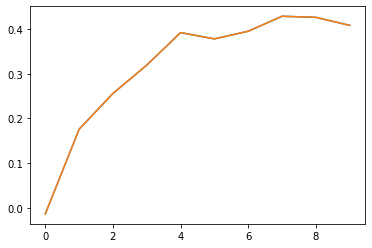

In [2]:
n_t = 10

mv = ModelVars(n_t=n_t)
model = mv.get_model()
prior = mv.get_prior()
data = {'y': np.load(f"data/data_{n_t}.npy")}

h = pyabc.History(f"sqlite:///cr_{n_t}_stochacc.db")

plt.plot(data['y'])
plt.plot(h.observed_sum_stat()['y'])
#help(h)

In [3]:
def normal_dty_1d(y_obs, y, sigma):
    dty = ( 1 / np.sqrt(2 * np.pi * sigma**2)
            * np.exp(-((y_obs - y) / sigma)**2 / 2) )
    return dty

def normal_dty(y_obs, y, sigma):
    dty = np.prod(1 / np.sqrt(2*np.pi*sigma**2) * np.exp(-((y_obs-y)/sigma)**2/2))
    return dty

uniform_pd = 1 / ((mv.limits['p0'][1] - mv.limits['p0'][0])
                  * (mv.limits['p1'][1] - mv.limits['p1'][0]))

def posterior_unscaled(p):
    if type(p) is not dict:
        p = {key: p[i] for i, key in enumerate(mv.p_true)}

    y = model(p)['y'].flatten()
    sigma = mv.noise_std * np.ones(mv.n_t)
    
    # likelihood
    likelihood_val = normal_dty(data['y'], y, sigma)
    
    # prior
    prior_val = prior.pdf(p)

    return likelihood_val * prior_val

def get_posterior_scaled():
    total = sp.integrate.dblquad(
        lambda p1, p0: posterior_unscaled([p0, p1]),
        mv.limits['p0'][0], mv.limits['p0'][1],
        lambda p1: mv.limits['p1'][0],
        lambda p1: mv.limits['p1'][1],
    )
    print("total: ", total)
    return lambda p: posterior_unscaled(p) / total[0]

posterior = get_posterior_scaled()

def marg_p0(p0):
    return sp.integrate.quad(
        lambda p1: posterior([p0, p1]),
            mv.limits['p1'][0], mv.limits['p1'][1])[0]

def marg_p1(p1):
    return sp.integrate.quad(
        lambda p0: posterior([p0, p1]),
            mv.limits['p0'][0], mv.limits['p0'][1])[0]

p0s = np.linspace(mv.limits['p0'][0], 0.15, 100)
val0s = [marg_p0(p0) for p0 in p0s]

p1s = np.linspace(mv.limits['p1'][0], 0.2, 100)
val1s = [marg_p1(p1) for p1 in p1s]

total:  (699930247.3952967, 411.45241759717464)


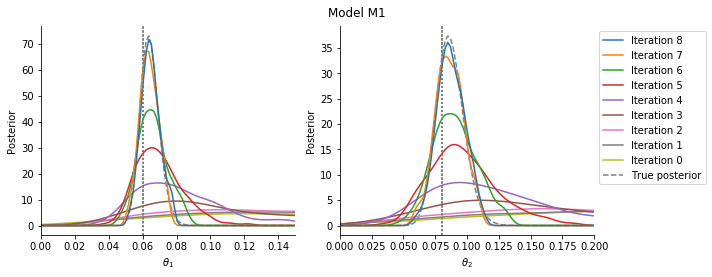

In [5]:
h = pyabc.History(f"sqlite:///cr_{n_t}_stochacc.db")

fig, arr_ax = plt.subplots(1, 2)

import copy
limits = copy.copy(mv.limits)
limits['p0'] = (mv.limits['p0'][0], 0.15)
limits['p1'] = (mv.limits['p1'][0], 0.2)


arr_ax[0].plot(p0s, val0s, '--', color='grey')
arr_ax[1].plot(p1s, val1s, '--', label="True posterior", color='grey')

for ip, p in enumerate(['p0', 'p1']):
    for t in range(0, h.max_t+1):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, t=t, x=p, xmin=limits[p][0], xmax=limits[p][1], numx=100,
            refval=mv.p_true, refval_color='grey', ax=arr_ax[ip], label=f"Iteration {t}",
            color=f'C{h.max_t-t}', #alpha=1/(h.max_t-t+1)
        )

handles, labels = arr_ax[1].get_legend_handles_labels()
arr_ax[1].legend(handles[::-1], labels[::-1], loc="upper left", bbox_to_anchor=(1, 1))

for i, ax in enumerate(arr_ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(f"$\\theta_{i+1}$")

fig.suptitle("Model M1")
fig.set_size_inches((10, 4))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for fmt in ['svg', 'eps']:
    plt.savefig(f"cr_{n_t}_alltimes.{fmt}", format=fmt)

## Some analysis for what to compare

In [4]:
arr_n_t = [3, 6, 10, 30, 60, 100, 300, 1000]
arr_approach = ['stochacc', 'stochacc_badc', 'rejection', 'rejection_badc', 'noisymodel']
#arr_approach = ['stochacc', 'stochacc_badc', 'rejection_badc', 'noisymodel']
mv = ModelVars()

max_ts = [11, 11, None, None, None, None, None, None]

arr_hs = []
success = []

for i, n_t in enumerate(arr_n_t):
    arr_hs.append([])
    success.append([])
    for approach in arr_approach:
        f = f"cr_{n_t}_{approach}.db"
        if not os.path.isfile(f):
            print(f, "does not exist")
            hs[i].append(None)
            success[i].append(False)
            continue
        _h = pyabc.History(f"sqlite:///{f}")
        arr_hs[i].append(_h)
        last_eps = _h.get_all_populations()['epsilon'].iloc[-1]
        success[i].append(True if (approach == 'noisymodel' and max_ts[i] is not None) or last_eps == 1.0 else False)
        if not success[i][-1]: print("Failure: ", approach, n_t)


success = np.array(success)
total_samples = []
for i, (n_t, max_t) in enumerate(zip(arr_n_t, max_ts)):
    total_samples.append([])
    for j, approach in enumerate(arr_approach):
        h = arr_hs[i][j]
        if h is None:
            total_samples[i].append(None)
            print(f"t={n_t} {approach} missing")
        else:
            s = h.get_all_populations()['samples']
            if j == 3 and max_t is not None:
                total_samples[i].append(np.sum(s[:max_t+1]))
            else:
                total_samples[i].append(np.sum(h.get_all_populations()['samples']))

total_samples = np.array(total_samples)
max_samples = np.max(total_samples)

Failure:  rejection_badc 3
Failure:  rejection_badc 6
Failure:  noisymodel 10
Failure:  stochacc_badc 30
Failure:  rejection 30
Failure:  rejection_badc 30
Failure:  noisymodel 30
Failure:  stochacc_badc 60
Failure:  rejection_badc 60
Failure:  noisymodel 60
Failure:  stochacc_badc 100
Failure:  rejection 100
Failure:  rejection_badc 100
Failure:  noisymodel 100
Failure:  stochacc_badc 300
Failure:  rejection_badc 300
Failure:  noisymodel 300
Failure:  stochacc_badc 1000
Failure:  rejection 1000
Failure:  rejection_badc 1000
Failure:  noisymodel 1000


## Choice of max_t for noisy models

In [8]:
# check kolmogorov smirnov distances. not used

from scipy.stats import ks_2samp

h_noisy = pyabc.History("sqlite:///cr_10_noisymodel.db")
h_stochacc = pyabc.History("sqlite:///cr_10_stochacc.db")

df, w = h_stochacc.get_distribution()
pars = df.to_dict('records')
resampled = pyabc.weighted_statistics.resample_deterministic(pars, w, 10 * len(w), enforce_n=True)

for t in range(h_noisy.max_t + 1):
    df_t, w_t = h_noisy.get_distribution(t=t)
    pars_t = df_t.to_dict('records')
    resampled_t = pyabc.weighted_statistics.resample_deterministic(pars_t, w_t, 10 * len(w_t), enforce_n=True)
    
    for p in resampled[0]:
        resampled_p = [par[p] for par in resampled]
        resampled_t_p = [par[p] for par in resampled_t]
        _, pv = ks_2samp(resampled_p, resampled_t_p)
        print(pv)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.194493523049377e-301
1e-323
2.454267449999112e-154
7.71134249851073e-161
9.175170802947736e-171
6.65459896429701e-131
1.1633754714723069e-76
1.0609579535436868e-85
1.4309870391417165e-35
8.211650861283168e-31
2.7806186723432776e-27
1.3502658545533624e-36
9.044370890233839e-23
2.461796075940553e-25
4.546796655228556e-62
7.288682240008833e-46
5.347305622662554e-26
3.4056831292405253e-15
1.1687456592824363e-29
1.4376338548973336e-13
1.5876925229001342e-191
2.108181721514734e-186
3.734381985672426e-157
6.712836425696043e-142


3
  stochacc
  stochacc_badc
  rejection
  rejection_badc
  noisymodel
  stochacc
  stochacc_badc
  rejection
  rejection_badc
  noisymodel
6
  stochacc
  stochacc_badc
  rejection
  rejection_badc
  noisymodel
  stochacc
  stochacc_badc
  rejection
  rejection_badc
  noisymodel
10
  stochacc


/home/yannik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


  stochacc_badc
  rejection
  rejection_badc
  noisymodel
  stochacc
  stochacc_badc
  rejection
  rejection_badc
  noisymodel
30
  stochacc
  stochacc_badc
  rejection
  rejection_badc
  noisymodel
  stochacc
  stochacc_badc
  rejection
  rejection_badc
  noisymodel
60
  stochacc
  stochacc_badc
  rejection
  rejection_badc
  noisymodel
  stochacc
  stochacc_badc
  rejection
  rejection_badc
  noisymodel
100
  stochacc
  stochacc_badc
  rejection
  rejection_badc
  noisymodel
  stochacc
  stochacc_badc
  rejection
  rejection_badc
  noisymodel
300
  stochacc
  stochacc_badc
  rejection
  rejection_badc
  noisymodel
  stochacc
  stochacc_badc
  rejection
  rejection_badc
  noisymodel
1000
  stochacc
  stochacc_badc
  rejection
  rejection_badc
  noisymodel
  stochacc
  stochacc_badc
  rejection
  rejection_badc
  noisymodel


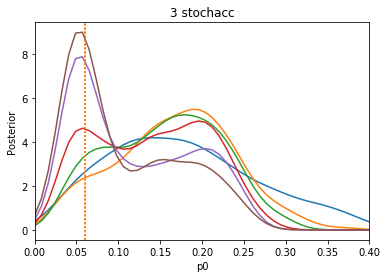

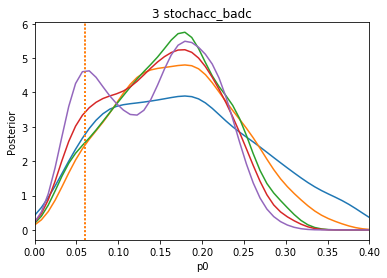

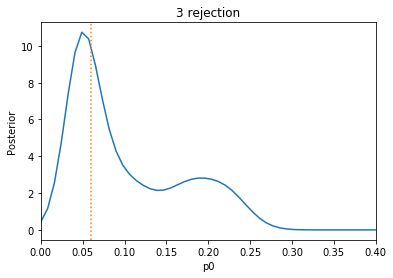

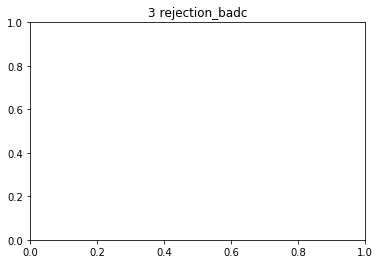

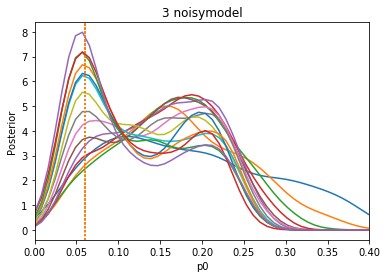

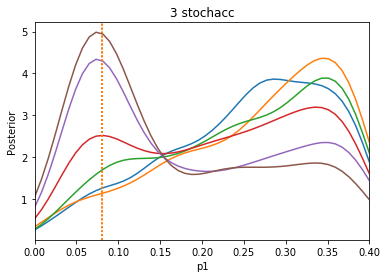

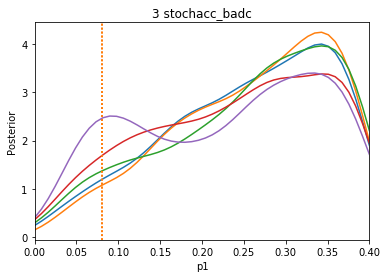

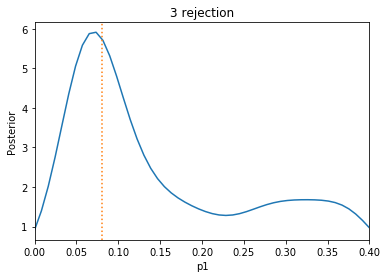

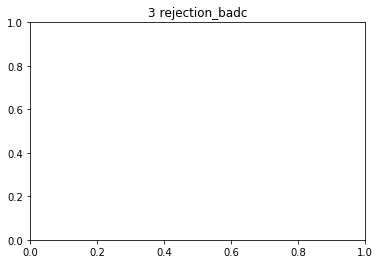

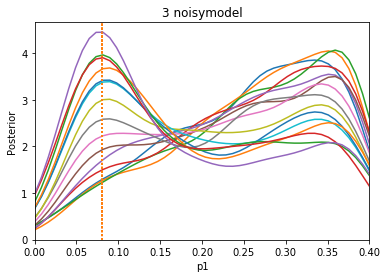

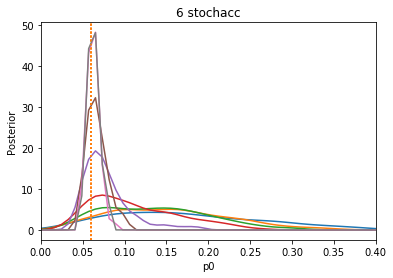

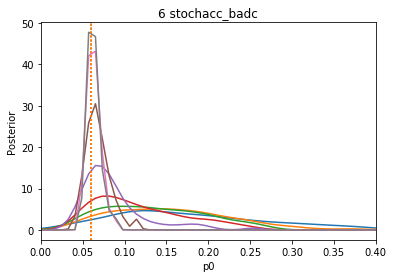

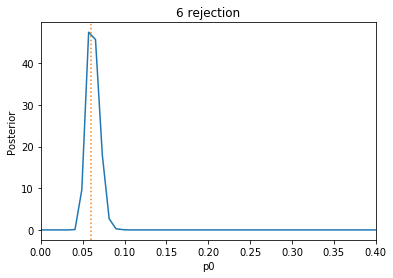

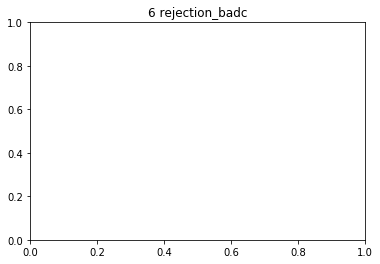

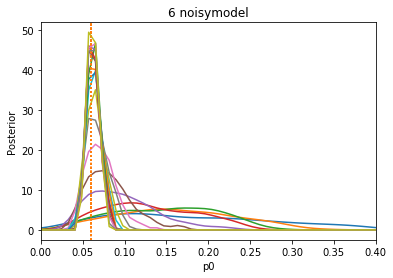

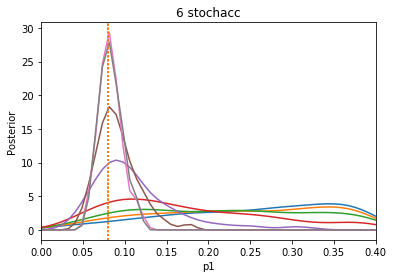

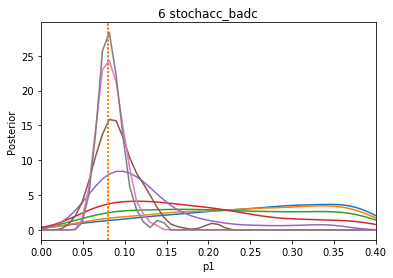

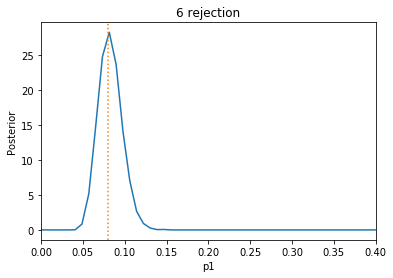

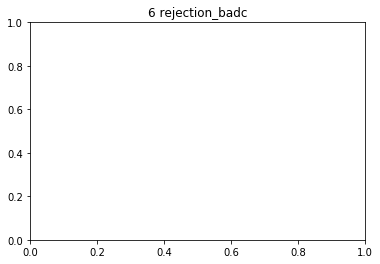

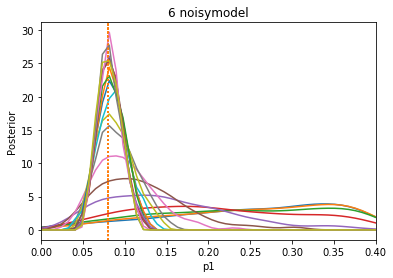

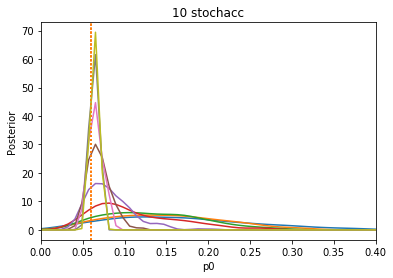

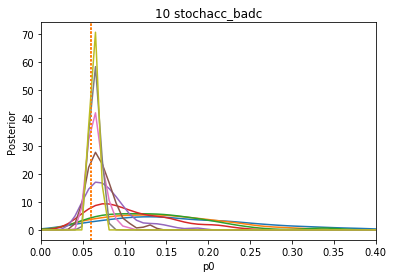

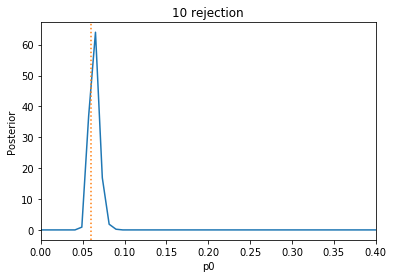

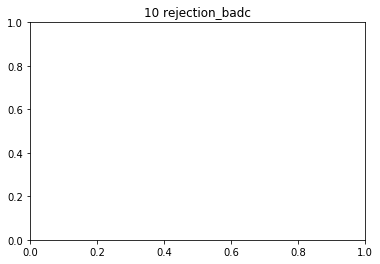

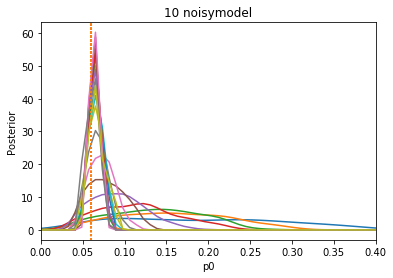

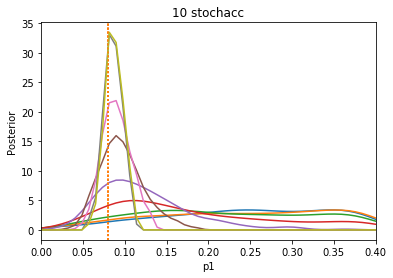

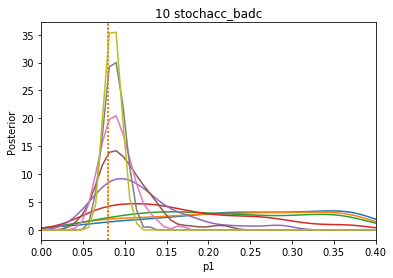

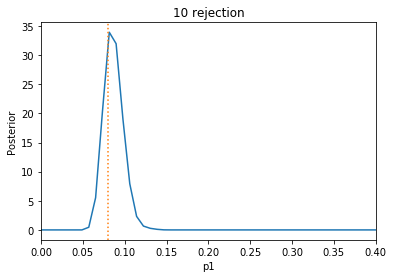

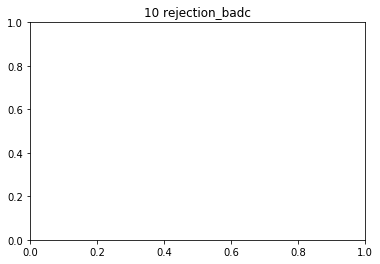

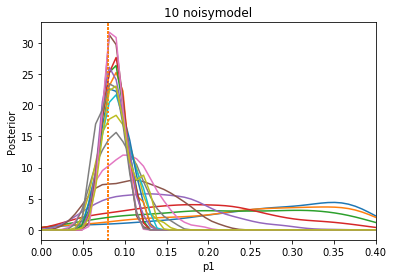

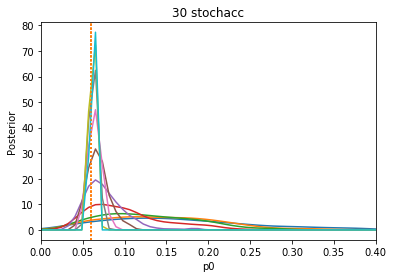

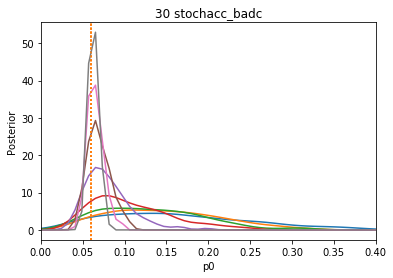

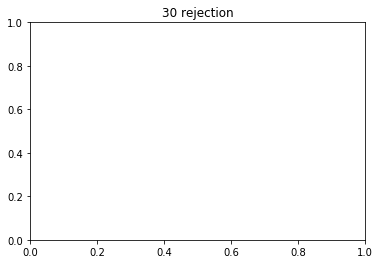

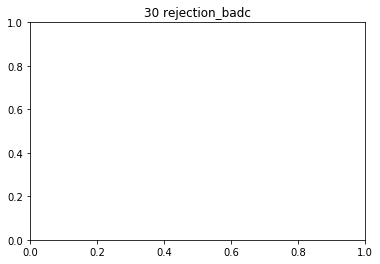

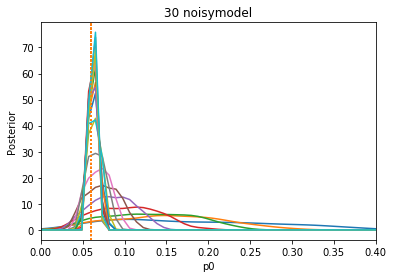

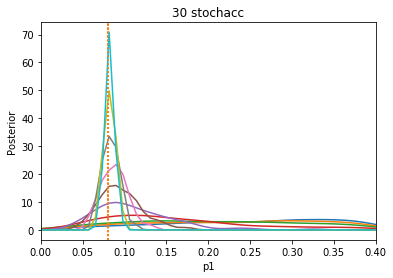

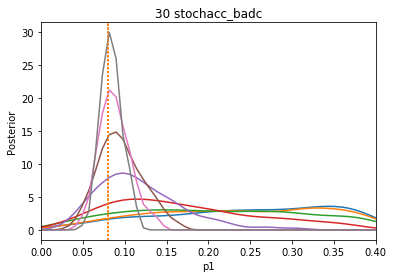

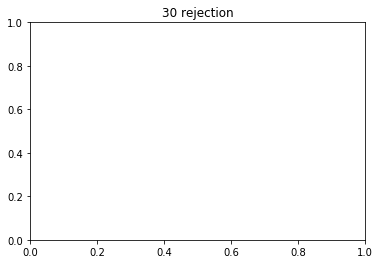

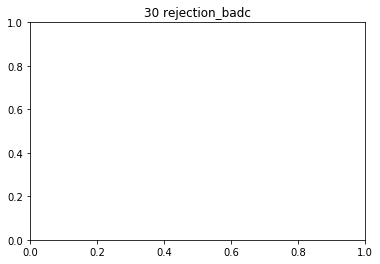

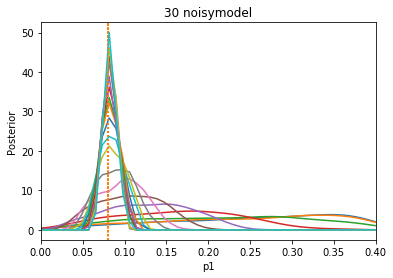

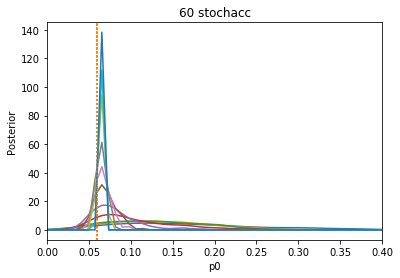

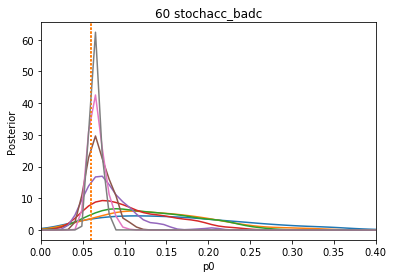

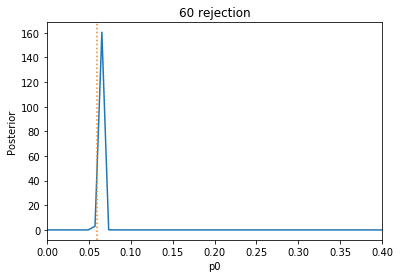

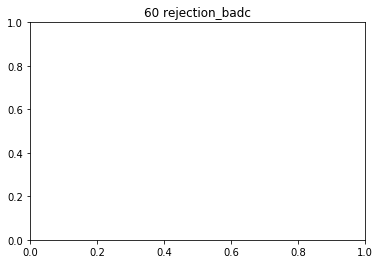

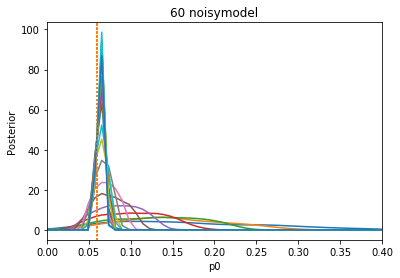

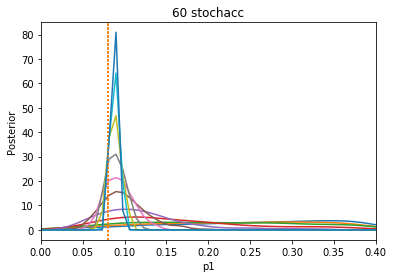

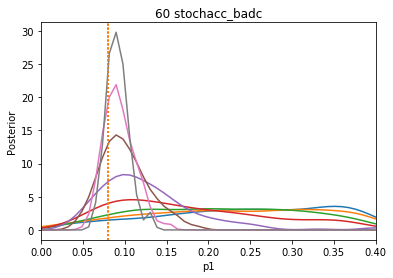

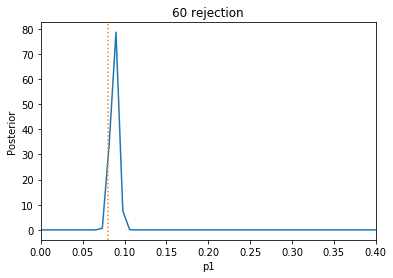

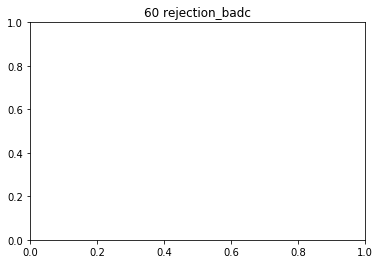

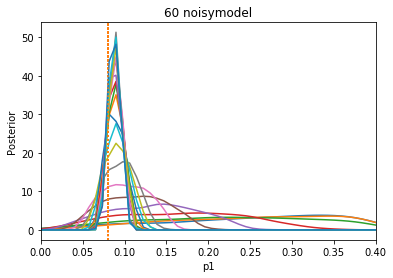

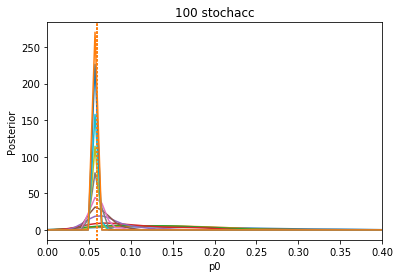

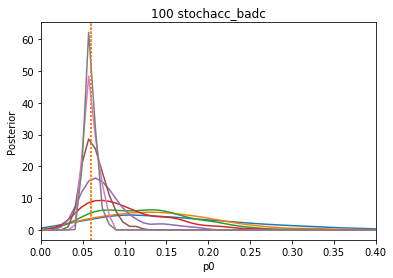

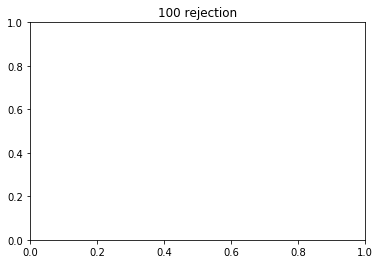

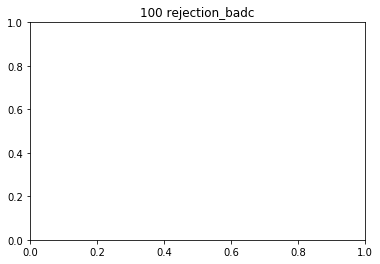

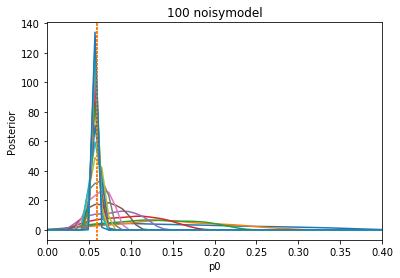

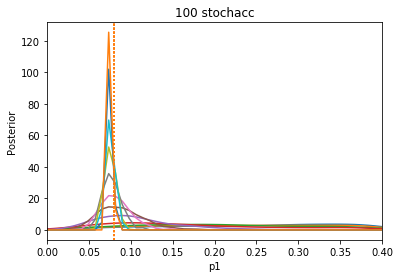

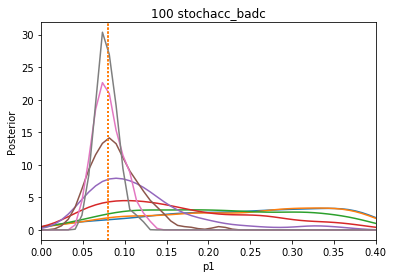

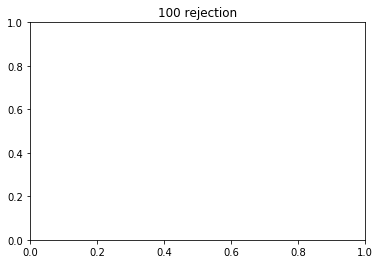

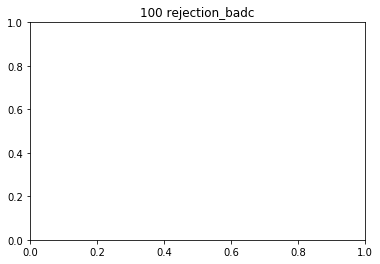

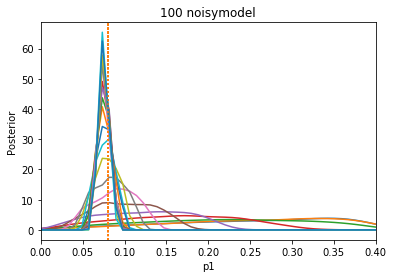

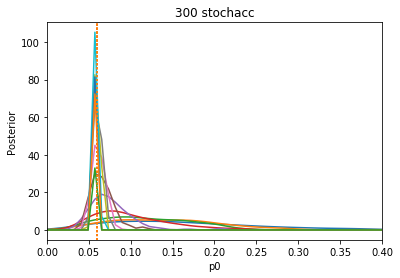

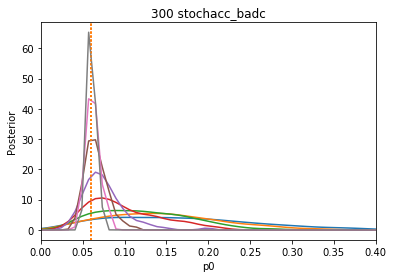

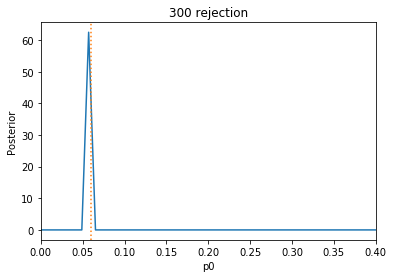

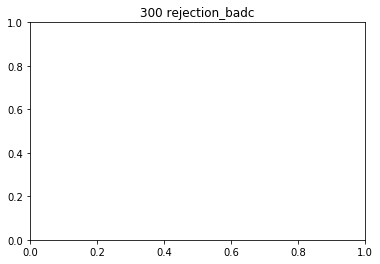

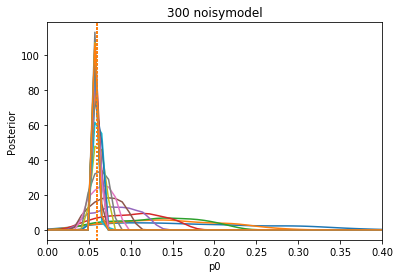

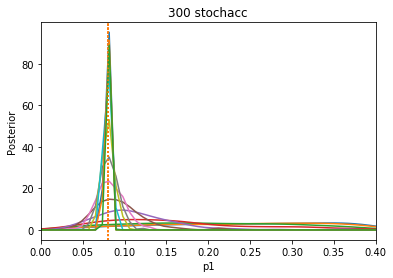

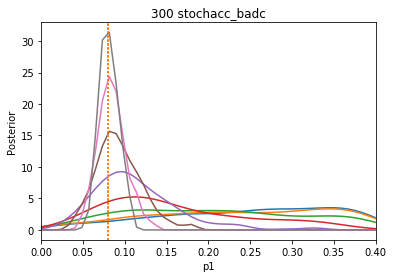

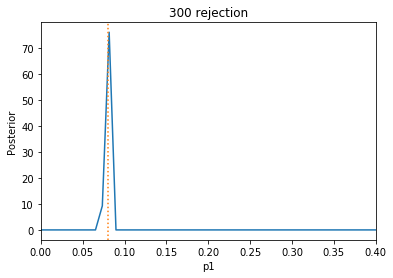

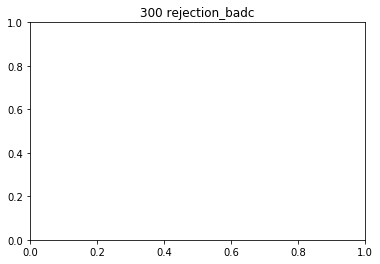

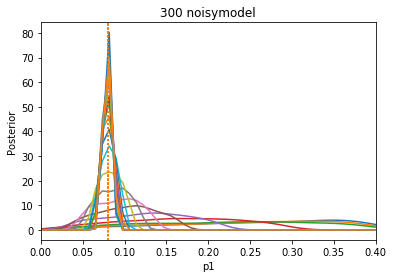

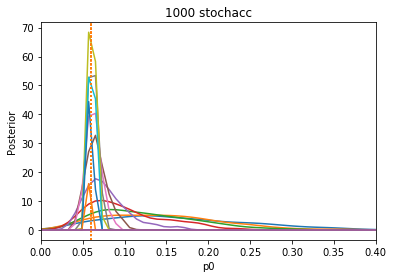

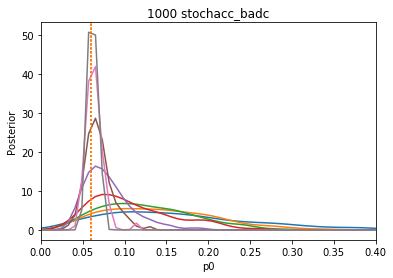

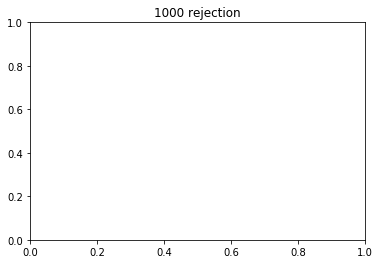

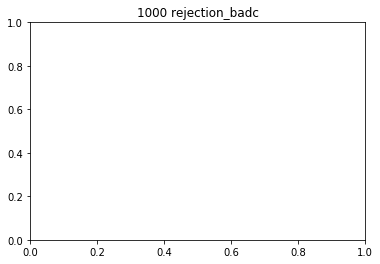

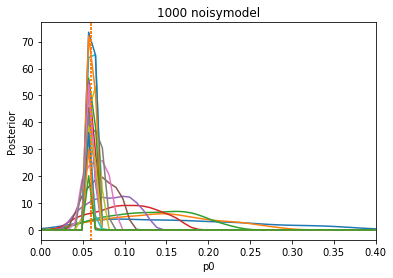

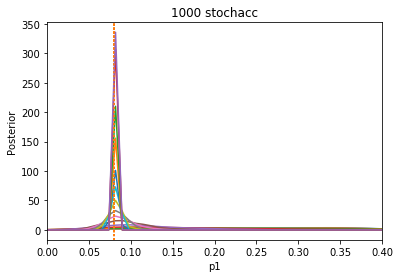

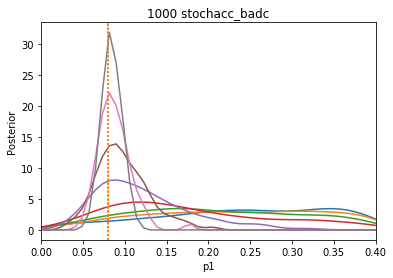

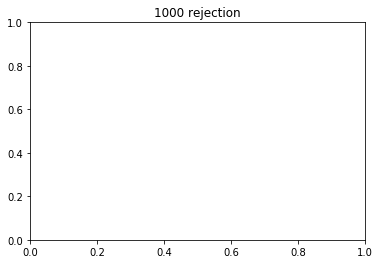

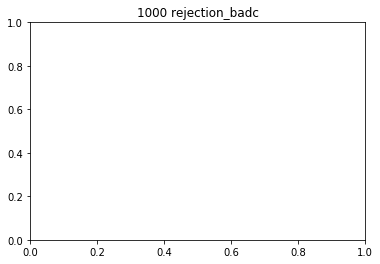

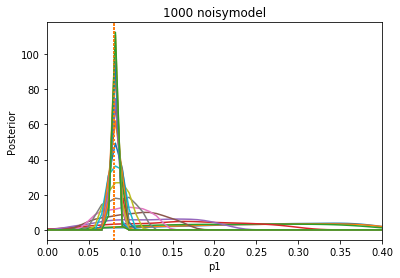

In [28]:
for t, hs in zip(arr_n_t, arr_hs):
    print(t)
    #_, ax = plt.subplots(1, 2)
    for ip, p in enumerate(mv.p_true):
        for h, approach in zip(hs, arr_approach):
            _, ax = plt.subplots()
            print(" ", approach)
            for _t in range(0, h.max_t + 1):
                pyabc.visualization.plot_kde_1d_highlevel(
                    h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], t=_t, 
                    ax=ax, refval=mv.p_true)
            plt.title(f"{t} {approach}")
            #ax.legend()

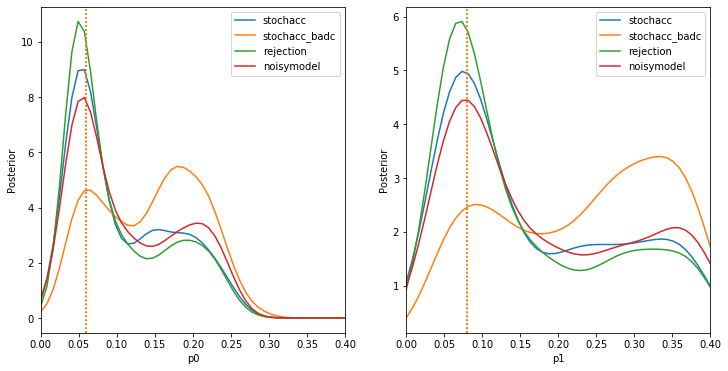

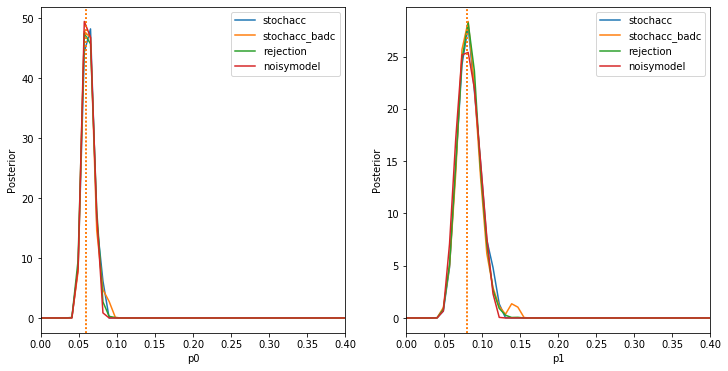

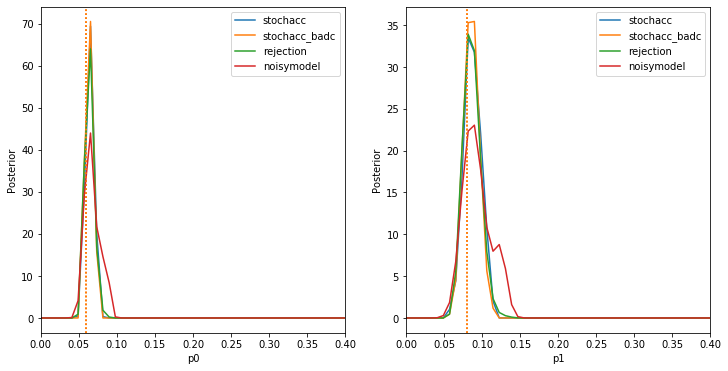

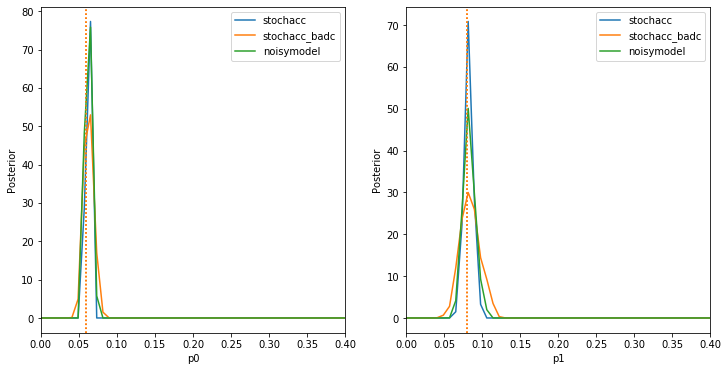

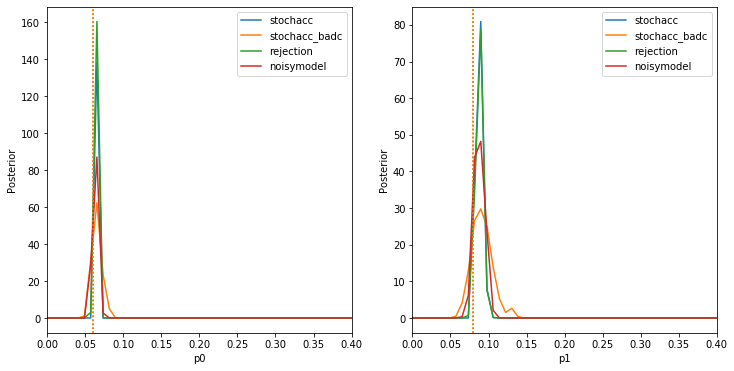

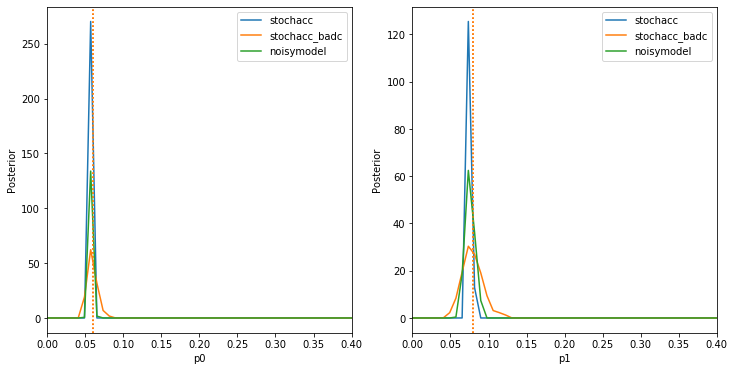

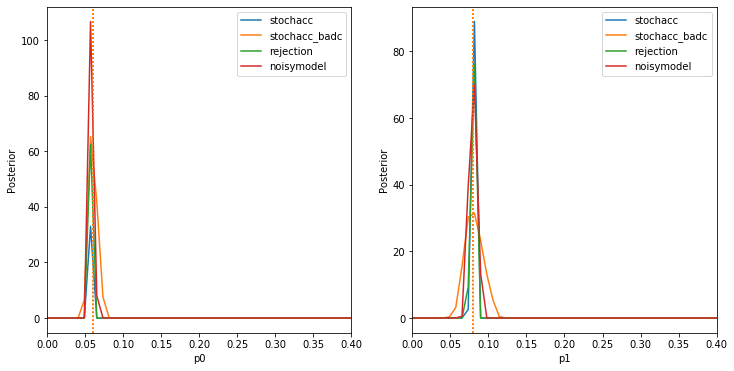

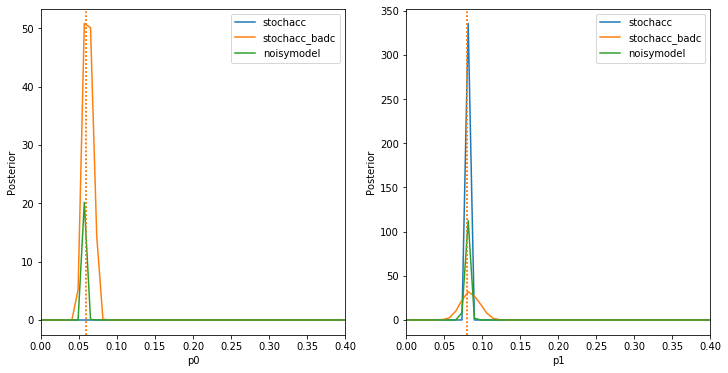

In [29]:
for t, hs in zip(arr_n_t, arr_hs):
    _, ax = plt.subplots(1, 2)
    for ip, p in enumerate(mv.p_true):
        for h, approach in zip(hs, arr_approach):
            if h.max_t >= 0:
                pyabc.visualization.plot_kde_1d_highlevel(
                    h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], t=None, 
                    ax=ax[ip], refval=mv.p_true, label=approach)
        ax[ip].legend()
    plt.gcf().set_size_inches((12, 6))

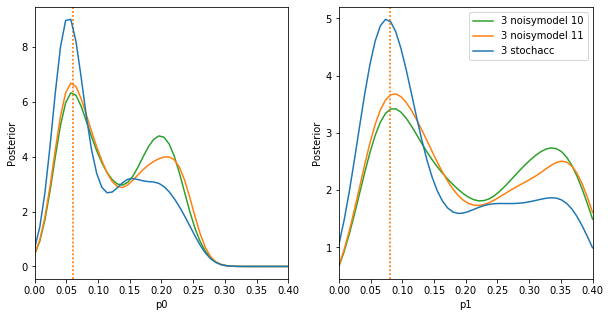

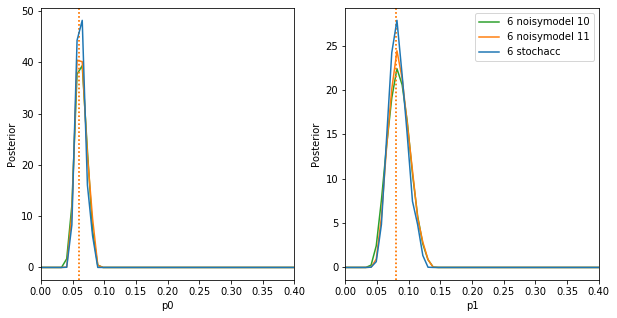

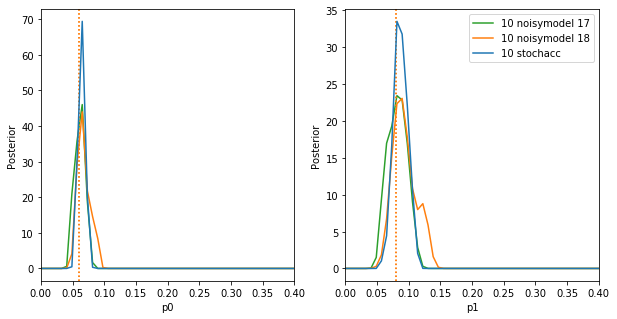

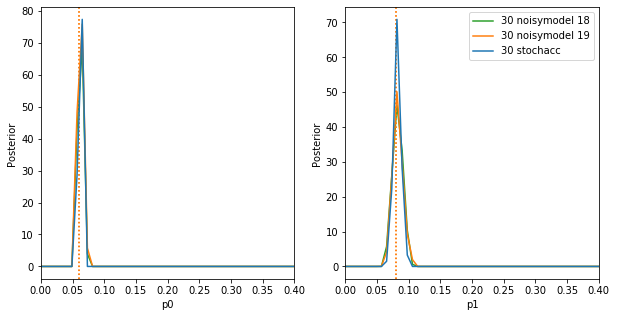

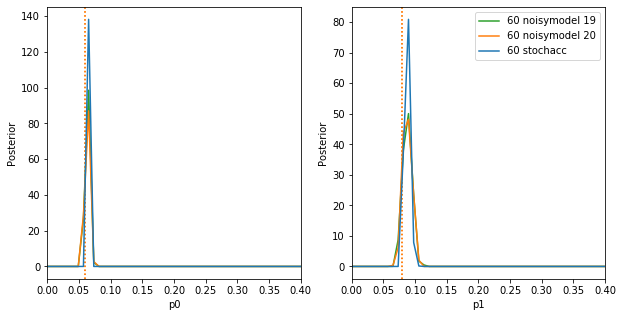

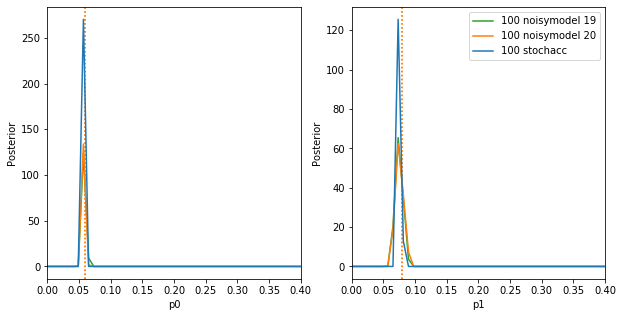

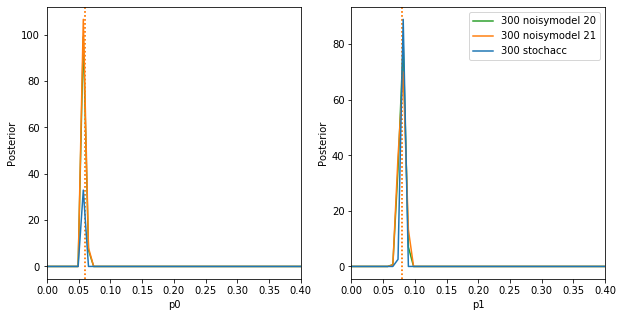

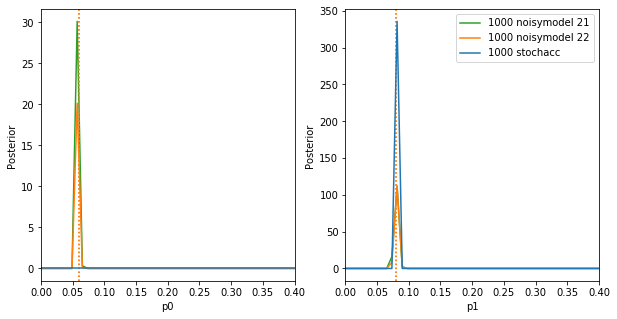

In [55]:
for t, hs, _t in zip(arr_n_t, arr_hs, [11, 11, None, None, None, None, None, None]):
    _, ax = plt.subplots(1, 2)
    h = hs[4]
    if _t is None:
        _t = h.max_t
    for ip, p in enumerate(mv.p_true):
        #for _t in range(h.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], t=_t-1,
            ax=ax[ip], refval=mv.p_true, label=f"{t} noisymodel {_t-1}", color='C2')
    for ip, p in enumerate(mv.p_true):
        #for _t in range(h.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], t=_t,
            ax=ax[ip], refval=mv.p_true, label=f"{t} noisymodel {_t}", color='C1')
    h = hs[0]
    for ip, p in enumerate(mv.p_true):
        #for _t in range(h.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(
            h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], t=None,
            ax=ax[ip], label=f"{t} stochacc", color='C0')
    plt.legend()
    plt.gcf().set_size_inches((10, 5))

## Bar plot comparison over the n_ts

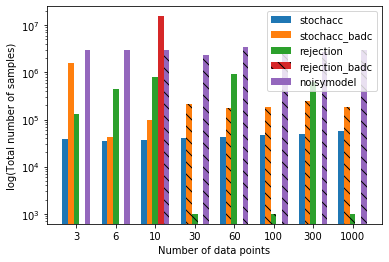

In [5]:
_, ax = plt.subplots()

maxi = np.max(total_samples)

time_indices = []

barwidth = 1 / (len(arr_approach) + 2)
for i, approach in enumerate(arr_approach):
    _samples = total_samples[:, i]
    _success = success[:, i]
    #for j, _s in enumerate(_success):
        #if not _s:
        #    _samples[j] = maxi
    p = np.arange(len(arr_n_t)) + (i+0.5-len(arr_approach)/2) * barwidth
    barc = ax.bar(p, _samples, width=barwidth, label=approach)
    for j, _s in enumerate(_success):
        if not _s:
            barc.patches[j].set_hatch('\\\\')
ax.set_yscale('log')
ax.set_xticks(np.arange(len(arr_n_t)))
ax.set_xticklabels(arr_n_t)
ax.legend(loc='upper right')
#ax.set_ylim([0, 2e6])
ax.set_xlabel("Number of data points")
ax.set_ylabel("log(Total number of samples)")

for fmt in ['svg', 'eps']:
    plt.savefig(f"cr_totalsamples.{fmt}", format=fmt)

3 38293 7896 804212.1422000534 4.355746625969378 8.97925341667042 101.85057525329957
10 36431 2212 22873.85980231842 27.594747040682915 29.93084472223473 10.340804612259683
30 40563 2897 66697506649.14639 72.84053175687629 89.7925341667042 23022957.07599116
100 47692 2616 7.560336685663776e+27 242.98513569974466 299.3084472223473 2.8900369593515966e+24
300 50012 2819 1.2357127735955893e+72 739.8717045143768 897.9253416670418 4.3835146278665815e+68
1000 56233 2644 1.155659985668665e+225 2482.738202903843 2993.084472223473 4.370877404193136e+221


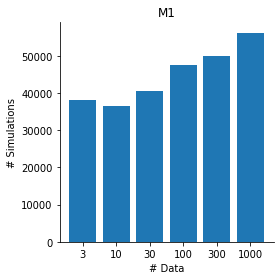

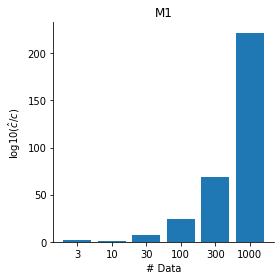

In [48]:
factors = []
arr_n_t = [3,10,30,100,300,1000]
n_d = len(arr_n_t)
arr_total_samples_assa = []

for n_t in arr_n_t:
    mv = ModelVars(n_t=n_t)
    kernel = mv.get_kernel()
    data = {'y': np.load(f"data/data_{n_t}.npy")}
    kernel.initialize(0, None, data)
    # the (too high) maximum density
    c_hat = kernel.pdf_max
    
    log_file = f"log/log_acceptor_cr_{n_t}_stochacc.json"
    df = pyabc.storage.load_dict_from_json(log_file)
    # the last (highest) used adaptive c (could be computed by optimization)
    c = df[max(df.keys())]
    
    h = pyabc.History(f"sqlite:///cr_{n_t}_stochacc.db", create=False)
    # number of samples in the last iteration
    samples = np.array(h.get_all_populations()['samples'])[-1]
    total_samples = sum(h.get_all_populations()['samples'])
    arr_total_samples_assa.append(total_samples)
    
    factor = np.exp(c_hat - c)
    factors.append(factor)
    
    samples_prediction = np.exp(c_hat - c) * samples
    print(n_t, total_samples, samples, samples_prediction, c, c_hat, samples_prediction / samples)
    
fig, ax = plt.subplots()
ax.bar(np.arange(n_d), arr_total_samples_assa)
ax.set_xticks(np.arange(n_d))
ax.set_xticklabels(arr_n_t)
ax.set_xlabel("# Data")
ax.set_ylabel("# Simulations")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("M1")
fig.set_size_inches((4,4))
fig.tight_layout()

for fmt in ['svg', 'eps']:
    plt.savefig(f"cr_datapoint_scaling_samples.{fmt}", format=fmt)

fig, ax = plt.subplots()
ax.bar(np.arange(n_d), np.log10(factors))
ax.set_xticks(np.arange(n_d))
ax.set_xticklabels(arr_n_t)
ax.set_xlabel("# Data")
ax.set_ylabel("log10($\hat c / c$)")
ax.set_title("M1")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.set_size_inches((4,4))
fig.tight_layout()

for fmt in ['svg', 'eps']:
    plt.savefig(f"cr_datapoint_scaling.{fmt}", format=fmt)

## Stuff

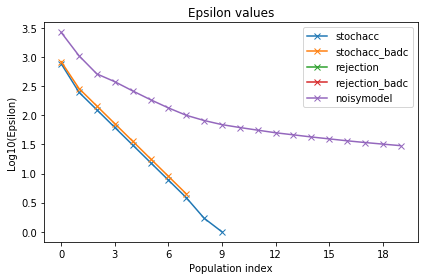

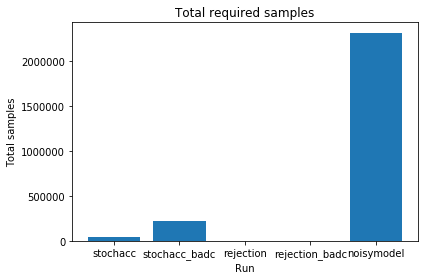

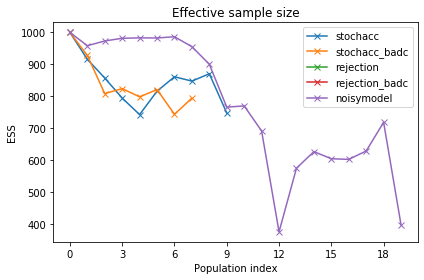

In [33]:
pyabc.visualization.plot_epsilons(arr_hs[3], arr_approach, scale='log10')
pyabc.visualization.plot_total_sample_numbers(arr_hs[3], arr_approach, yscale='lin')
pyabc.visualization.plot_effective_sample_sizes(arr_hs[3], arr_approach)


[<pyabc.storage.history.History object at 0x7f5b62c1a470>, <pyabc.storage.history.History object at 0x7f5b62d332e8>, <pyabc.storage.history.History object at 0x7f5b62ed9668>, <pyabc.storage.history.History object at 0x7f5b62ed9be0>]


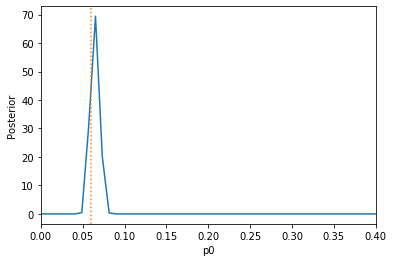

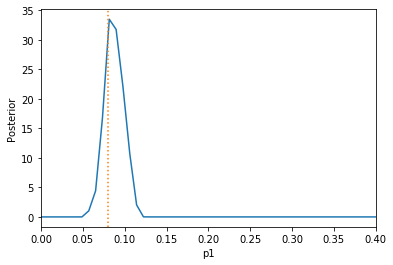

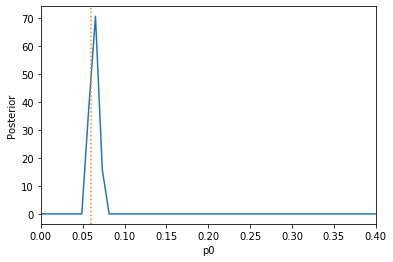

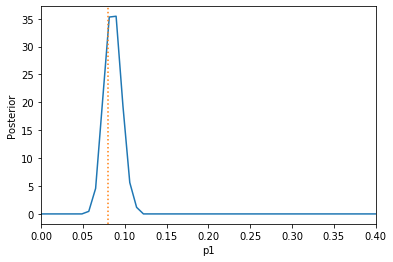

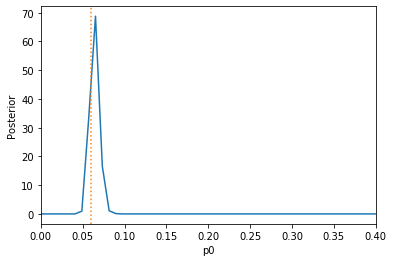

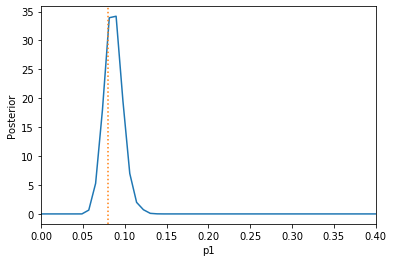

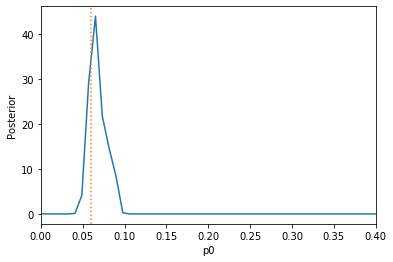

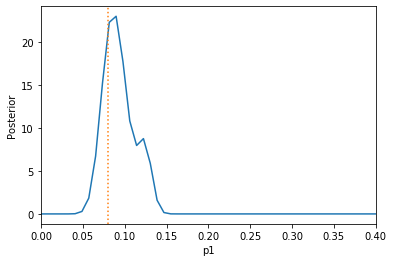

In [15]:
print(hs[2])
def plot_posterior(_h):
    for p in mv.p_true:
        _, ax = plt.subplots()
        #for t in range(_h.max_t+1):
        pyabc.visualization.plot_kde_1d_highlevel(
            _h, x=p, xmin=mv.limits[p][0], xmax=mv.limits[p][1], t=None, ax=ax, refval=mv.p_true)

for i in range(4):
    plot_posterior(hs[2][i])


## Data

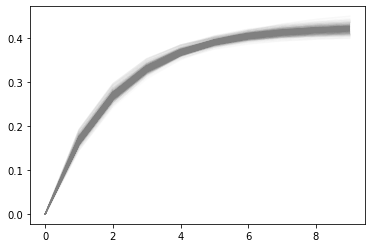

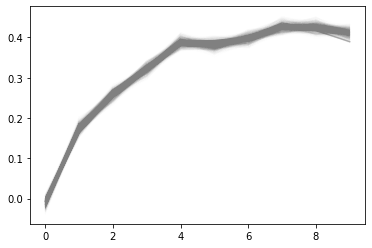

In [4]:
def plot_data(sum_stat, weight, ax, **kwargs):
    ax.plot(sum_stat['y'], color='grey', alpha=5*weight)
    
pyabc.visualization.plot_data_callback(hs[10][0], plot_data)
pyabc.visualization.plot_data_callback(hs[10][2], plot_data)

## Trajectory of c

In [44]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pyabc
from study_abc_noise.model import ConversionReactionModelVars as ModelVars

n_t = 100
c_dct = pyabc.storage.load_dict_from_json(f"log/log_acceptor_cr_{n_t}_stochacc.json")

mv = ModelVars(n_t=n_t)
h = pyabc.History(f"sqlite:///cr_{n_t}_stochacc.db")
data = h.observed_sum_stat()

ts = list(c_dct.keys())
values = list(c_dct.values())

stuff = pyabc.storage.load_dict_from_json

In [45]:
# optimize

from study_abc_noise.optimize import multistart_on_kernel

# optimize
result = multistart_on_kernel(mv, data)

kernel_l1 = pyabc.distance.IndependentLaplaceKernel(
    mv.noise_std * np.ones(mv.n_t))

result_l1 = multistart_on_kernel(mv, data, kernel_l1)

# l2
optimal_parameter = result.optimize_result.get_for_key('x')[0]
optimal_value = result.optimize_result.get_for_key('fval')[0]
print("optimal parameter l2: ", optimal_parameter)
print("optimal value l2: ", optimal_value)

INFO:pypesto.engine.task:Executing task 0.
INFO:pypesto.optimize.optimizer:Final fval=-242.9852, time=0.0721s, n_fval=45.
INFO:pypesto.engine.task:Executing task 1.
INFO:pypesto.optimize.optimizer:Final fval=-242.9852, time=0.0857s, n_fval=48.
INFO:pypesto.engine.task:Executing task 2.
INFO:pypesto.optimize.optimizer:Final fval=-242.9852, time=0.0786s, n_fval=48.
INFO:pypesto.engine.task:Executing task 3.
INFO:pypesto.optimize.optimizer:Final fval=-242.9852, time=0.0799s, n_fval=48.
INFO:pypesto.engine.task:Executing task 4.
INFO:pypesto.optimize.optimizer:Final fval=-242.9852, time=0.1230s, n_fval=84.
INFO:pypesto.engine.task:Executing task 5.
/home/yannik/Documents/Project8_pyABC_Noise/Study-ABC-Noise/study_abc_noise/model/conversion_reaction.py:225: RuntimeWarning: divide by zero encountered in double_scalars
  A = 1 / (- p0 - p1) * np.array([[- p1 - p0 * e, - p1 + p1 * e],
/home/yannik/Documents/Project8_pyABC_Noise/Study-ABC-Noise/study_abc_noise/model/conversion_reaction.py:226: 

INFO:pypesto.engine.task:Executing task 63.
INFO:pypesto.optimize.optimizer:Final fval=-242.9852, time=0.2042s, n_fval=135.
INFO:pypesto.engine.task:Executing task 64.
INFO:pypesto.optimize.optimizer:Final fval=-242.9852, time=0.0792s, n_fval=51.
INFO:pypesto.engine.task:Executing task 65.
INFO:pypesto.optimize.optimizer:Final fval=-242.9852, time=0.1504s, n_fval=114.
INFO:pypesto.engine.task:Executing task 66.
INFO:pypesto.optimize.optimizer:Final fval=-242.9852, time=0.2322s, n_fval=174.
INFO:pypesto.engine.task:Executing task 67.
INFO:pypesto.optimize.optimizer:Final fval=-242.9852, time=0.0801s, n_fval=54.
INFO:pypesto.engine.task:Executing task 68.
INFO:pypesto.optimize.optimizer:Final fval=-242.9852, time=0.1842s, n_fval=132.
INFO:pypesto.engine.task:Executing task 69.
INFO:pypesto.optimize.optimizer:Final fval=-242.9852, time=0.0774s, n_fval=48.
INFO:pypesto.engine.task:Executing task 70.
INFO:pypesto.optimize.optimizer:Final fval=-242.9852, time=0.0897s, n_fval=57.
INFO:pypesto

INFO:pypesto.optimize.optimizer:Final fval=-239.8293, time=0.4896s, n_fval=342.
INFO:pypesto.engine.task:Executing task 30.
INFO:pypesto.optimize.optimizer:Final fval=-239.8323, time=0.4182s, n_fval=315.
INFO:pypesto.engine.task:Executing task 31.
INFO:pypesto.optimize.optimizer:Final fval=-239.8295, time=0.8719s, n_fval=660.
INFO:pypesto.engine.task:Executing task 32.
INFO:pypesto.optimize.optimizer:Final fval=-239.8320, time=0.3859s, n_fval=288.
INFO:pypesto.engine.task:Executing task 33.
INFO:pypesto.optimize.optimizer:Final fval=-239.8321, time=0.3640s, n_fval=273.
INFO:pypesto.engine.task:Executing task 34.
INFO:pypesto.optimize.optimizer:Final fval=-239.8316, time=0.3500s, n_fval=258.
INFO:pypesto.engine.task:Executing task 35.
INFO:pypesto.optimize.optimizer:Final fval=-239.8303, time=0.6142s, n_fval=447.
INFO:pypesto.engine.task:Executing task 36.
INFO:pypesto.optimize.optimizer:Final fval=-239.8323, time=0.3973s, n_fval=279.
INFO:pypesto.engine.task:Executing task 37.
INFO:pyp

INFO:pypesto.engine.task:Executing task 96.
INFO:pypesto.optimize.optimizer:Final fval=-239.8305, time=0.6093s, n_fval=354.
INFO:pypesto.engine.task:Executing task 97.
INFO:pypesto.optimize.optimizer:Final fval=-239.8323, time=0.2218s, n_fval=165.
INFO:pypesto.engine.task:Executing task 98.
INFO:pypesto.optimize.optimizer:Final fval=-239.8315, time=0.3680s, n_fval=288.
INFO:pypesto.engine.task:Executing task 99.
INFO:pypesto.optimize.optimizer:Final fval=-239.8323, time=0.3025s, n_fval=222.


optimal parameter l2:  [0.05708298 0.07436306]
optimal value l2:  -242.9851861006996


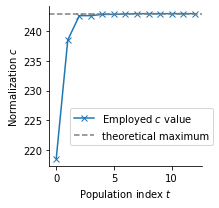

In [50]:
fig, ax = plt.subplots()
ax.plot(ts, values, 'x-', label='Employed $c$ value')
ax.axhline(-optimal_value, color='grey', linestyle='--', label="theoretical maximum")
ax.legend(loc="lower left", bbox_to_anchor=(0.1, 0.1))
ax.set_xlabel("Population index $t$")
ax.set_ylabel("Normalization $c$")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.set_size_inches(((3, 3)))
fig.tight_layout()
for fmt in ['svg', 'eps']:
    plt.savefig(f"c_trajectory.{fmt}", format=fmt)

## Proposed temperatures

{0: [47.96909220921619], 1: [8.751781559046716, 23.984546104608096], 2: [5.007345299052888, 4.375890779523358], 3: [3.7089570663764078, 2.187945389761679], 4: [2.8646218549138918, 1.0939726948808395], 5: [2.2036387856263056, 0.5469863474404197], 6: [1.9937286399490626, 0.5]}
[47.96909220921619, 8.751781559046716, 5.007345299052888, 3.7089570663764078, 2.8646218549138918, 2.2036387856263056] [23.984546104608096, 4.375890779523358, 2.187945389761679, 1.0939726948808395, 0.5469863474404197]
{0: [218.5124610412517], 1: [75.28737239595523, 109.25623052062585], 2: [43.90689203481943, 37.643686197977615], 3: [30.813040718553733, 18.821843098988808], 4: [17.658928859811404, 9.410921549494404], 5: [6.794904207268047, 4.705460774747202], 6: [2.4954908240145217, 2.352730387373601], 7: [1.2680741774904392, 1.1763651936868005], 8: [1.0, 0.5881825968434002], 9: [1.0, 0.5]}
[218.5124610412517, 75.28737239595523, 43.90689203481943, 30.813040718553733, 17.658928859811404, 6.794904207268047, 2.495490824

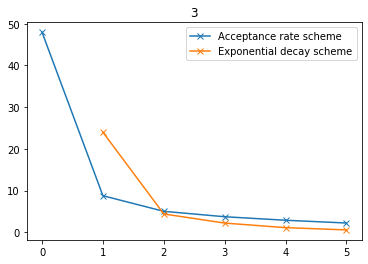

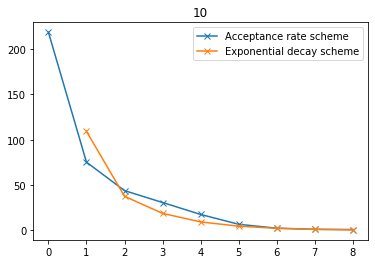

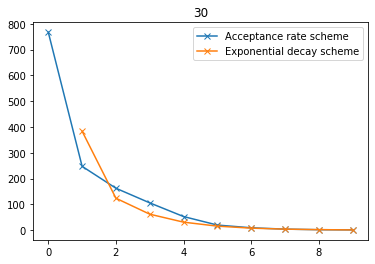

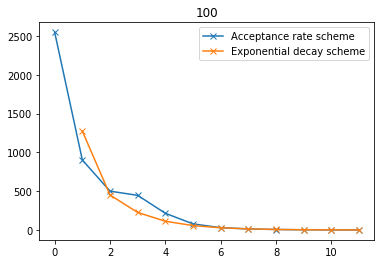

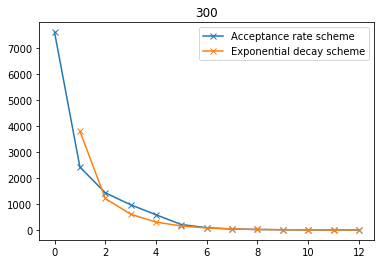

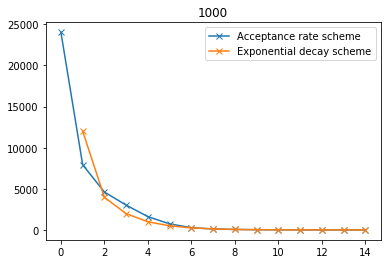

In [17]:
for n_t in [3,10,30,100,300,1000]:

    t_dct = pyabc.storage.load_dict_from_json(f"log/log_temperature_cr_{n_t}_stochacc.json")
    print(t_dct)

    ts_accrate = np.arange(max(t_dct))
    ts_decay = np.arange(1, max(t_dct))

    vals_accrate = [t_dct[t][0] for t in ts_accrate]
    vals_decay = [t_dct[t][1] for t in ts_decay]

    print(vals_accrate, vals_decay)

    fig, ax = plt.subplots()
    ax.plot(ts_accrate,vals_accrate, 'x-', label='Acceptance rate scheme')
    ax.plot(ts_decay, vals_decay, 'x-', label='Exponential decay scheme')
    ax.legend()
    ax.set_title(n_t)


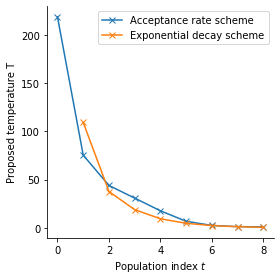

In [23]:
n_t = 10

t_dct = pyabc.storage.load_dict_from_json(f"log/log_temperature_cr_{n_t}_stochacc.json")

ts_accrate = np.arange(max(t_dct))
ts_decay = np.arange(1, max(t_dct))

vals_accrate = [t_dct[t][0] for t in ts_accrate]
vals_decay = [t_dct[t][1] for t in ts_decay]

fig, ax = plt.subplots()

ax.plot(ts_accrate,vals_accrate, 'x-', label='Acceptance rate scheme')
ax.plot(ts_decay, vals_decay, 'x-', label='Exponential decay scheme')
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Population index $t$")
ax.set_ylabel("Proposed temperature T")
fig.set_size_inches(((4, 4)))
fig.tight_layout()
for fmt in ['svg', 'eps']:
    plt.savefig(f"cr_temp_schemes_{n_t}.{fmt}", format=fmt)